# Himanshu Generic UDE Framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from ude_framework import (
    DataGenerator, 
    create_ode_system,
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")


✓ UDE Framework loaded!


In [50]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. TRUE ODE SYSTEM (for generating data)
# ----------------------------------------------------------------------------
def true_ode_equations(t, y, params):
    """
    Define your TRUE ODE system here.
    This will be used to generate synthetic data.
    
    Args:
        t: time
        y: state variables (list/array)
        params: dictionary of parameters
    Returns:
        list of derivatives [dy1/dt, dy2/dt, ...]
    """
    # Example: Hill activation system
    X, Y = y
    v, K, n, d = params['v'], params['K'], params['n'], params['d']
    
    hill_term = (Y**n) / (K**n + Y**n)
    dX_dt = v * hill_term - d * X
    dY_dt = X - d * Y
    
    return [dX_dt, dY_dt]

# True system parameters
TRUE_PARAMS = {
    'v': 10.0,  # max production
    'K': 1.0,   # Hill constant
    'n': 3.0,   # Hill coefficient
    'd': 1   # degradation
}

# State variable names
STATE_NAMES = ['X', 'Y']

# Initial conditions
INITIAL_CONDITIONS = np.array([2.0, 0.1])

# Time settings
T_START = 0.0
T_END = 45.0
N_POINTS = 1000

# Noise settings
NOISE_LEVEL = 0.05  # 5% relative noise
NOISE_TYPE = 'relative'  # 'relative' or 'absolute'

# ----------------------------------------------------------------------------
# 2. UDE STRUCTURE (partial known + NN for unknown)
# ----------------------------------------------------------------------------
def ude_ode_equations(t, y, nn_outputs, known_params):
    """
    Define your UDE here!
    Combine KNOWN physics with UNKNOWN terms learned by neural networks.
    
    Args:
        t: time
        y: state tensor (..., n_states)
        nn_outputs: dict of NN outputs (e.g., nn_outputs['my_nn'])
        known_params: dict of known parameters
    Returns:
        dy/dt tensor
    """
    # Extract states
    X = y[..., 0:1]
    Y = y[..., 1:2]
    
    # Get NN output (unknown Hill function)
    nn_activation = nn_outputs['hill_nn']
    if nn_activation.dim() > 2:
        nn_activation = nn_activation.squeeze(-1)
    
    # Known parameters
    d = known_params['d']
    
    # KNOWN: degradation and linear production
    # UNKNOWN: Hill activation (learned by NN)
    dX_dt = nn_activation - d * X
    dY_dt = X - d * Y
    
    return torch.cat([dX_dt, dY_dt], dim=-1)

# Known parameters for UDE
KNOWN_PARAMS = {
    'd': 1.0  # We assume degradation is known
}

# ----------------------------------------------------------------------------
# 3. NEURAL NETWORK CONFIGURATION
# ----------------------------------------------------------------------------
# What does the NN take as input? What does it output?
NN_INPUT_DIM = 1   # e.g., Y concentration
NN_OUTPUT_DIM = 1  # e.g., activation term

# Which state(s) to feed to NN?
def nn_input_extractor(y):
    """Extract input for NN from state vector y"""
    # e.g., for Hill function, input is Y (second state)
    return y[..., 1:2]  # Returns Y

# Architecture
NN_ARCHITECTURE = 'flexible'  # 'flexible' or 'residual'
NN_CONFIG = {
    'hidden_dims': [128, 128, 128],  # [layer1_size, layer2_size, ...]
    'activation': 'tanh',             # 'tanh', 'relu', 'elu', 'silu', 'gelu'
    'final_activation': None,         # None, 'softplus', 'sigmoid'
    'use_batch_norm': False,
    'dropout': 0.0
}

# Name your NN (must match nn_outputs key in ude_ode_equations)
NN_NAME = 'hill_nn'

# ----------------------------------------------------------------------------
# 4. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 300
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'  # 'adam', 'adamw', 'sgd', 'rmsprop'
WEIGHT_DECAY = 0.0
GRAD_CLIP = 0.1     # None for no clipping

# Learning rate scheduler
SCHEDULER_TYPE = 'plateau'  # 'plateau', 'cosine', 'step', 'exponential', None
SCHEDULER_PARAMS = {
    'factor': 0.5,
    'patience': 100,
    'min_lr': 1e-6,
    'verbose': False
}

# ODE solver
ODE_SOLVER = 'dopri5'  # 'dopri5', 'dopri8', 'rk4', 'euler'
ODE_RTOL = 1e-6
ODE_ATOL = 1e-8

# Loss
LOSS_TYPE = 'mse'  # 'mse', 'mae', 'huber'
STATE_WEIGHTS = None  # None or torch.tensor([w1, w2, ...])

PRINT_EVERY = 10

# ----------------------------------------------------------------------------
# 5. OPTIONAL: TRUE FUNCTION (for comparison with learned NN)
# ----------------------------------------------------------------------------
def true_function_for_comparison(nn_input):
    """
    Define the TRUE function that the NN is trying to learn.
    This is optional but useful for visualization.
    
    Args:
        nn_input: numpy array of inputs
    Returns:
        numpy array of outputs
    """
    # Example: true Hill function
    Y = nn_input
    v, K, n = TRUE_PARAMS['v'], TRUE_PARAMS['K'], TRUE_PARAMS['n']
    return v * (Y**n) / (K**n + Y**n)

# Range for function comparison plot
FUNCTION_INPUT_RANGE = np.linspace(0, 6, 300)
FUNCTION_INPUT_NAME = 'Y Concentration'
FUNCTION_OUTPUT_NAME = 'Activation Term'

print("✓ Configuration complete!")


✓ Configuration complete!


# 1. Generate Data


In [51]:
# Create true ODE system
true_system = create_ode_system(
    name="True System",
    equations=true_ode_equations,
    params=TRUE_PARAMS,
    state_names=STATE_NAMES
)

# Generate data
data_gen = DataGenerator(true_system)
data = data_gen.generate(
    initial_conditions=INITIAL_CONDITIONS,
    t_span=(T_START, T_END),
    n_points=N_POINTS,
    noise_level=NOISE_LEVEL,
    noise_type=NOISE_TYPE,
    random_seed=42
)

t = data['t']
y_true = data['y_true']
y_noisy = data['y_noisy']
y0 = data['y0']

print(f"✓ Generated {len(t)} points from t={T_START} to {T_END}")
print(f"  States: {STATE_NAMES}")
print(f"  Noise: {NOISE_LEVEL*100}% {NOISE_TYPE}")


✓ Generated 1000 points from t=0.0 to 45.0
  States: ['X', 'Y']
  Noise: 5.0% relative


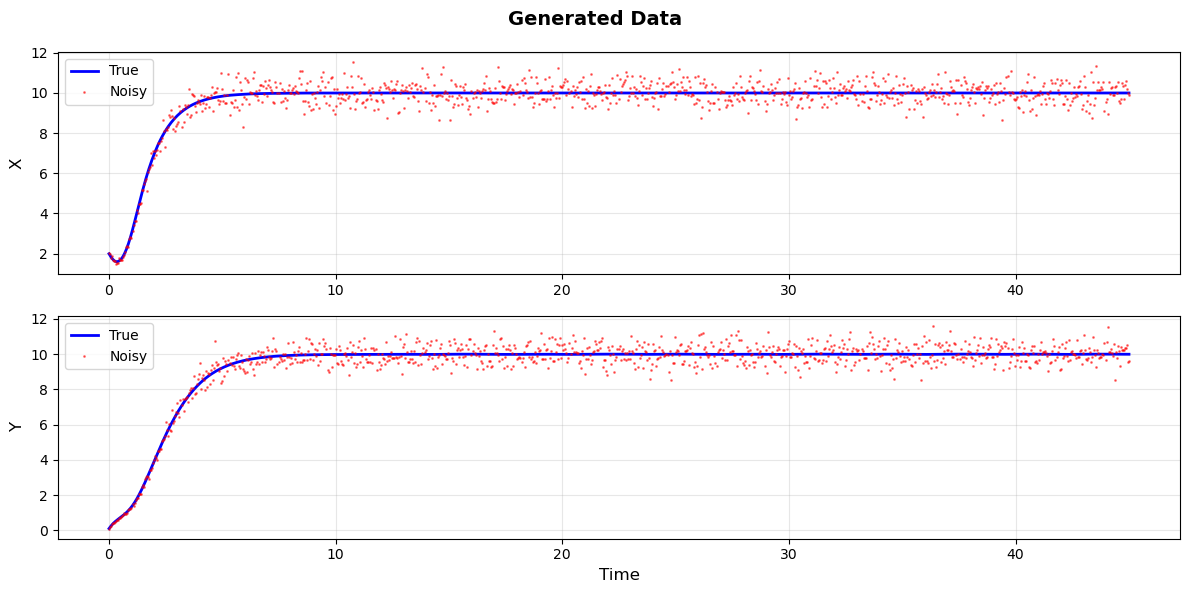

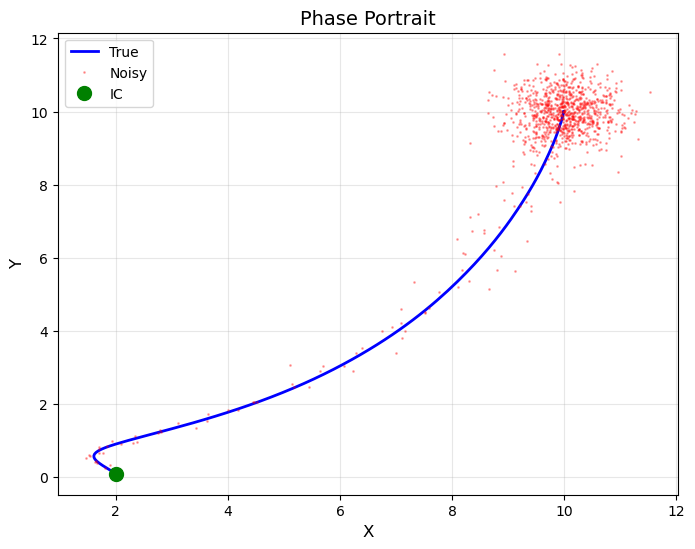

In [52]:
# Visualize data
n_states = len(STATE_NAMES)
fig, axes = plt.subplots(n_states, 1, figsize=(12, 3*n_states))
if n_states == 1:
    axes = [axes]

for i, (ax, name) in enumerate(zip(axes, STATE_NAMES)):
    ax.plot(t, y_true[:, i], 'b-', label=f'True', linewidth=2)
    ax.plot(t, y_noisy[:, i], 'r.', label=f'Noisy', alpha=0.5, markersize=2)
    ax.set_ylabel(name, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
plt.suptitle('Generated Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Phase portrait
if n_states >= 2:
    plt.figure(figsize=(8, 6))
    plt.plot(y_true[:, 0], y_true[:, 1], 'b-', linewidth=2, label='True')
    plt.plot(y_noisy[:, 0], y_noisy[:, 1], 'r.', alpha=0.3, markersize=2, label='Noisy')
    plt.plot(y0[0], y0[1], 'go', markersize=10, label='IC', zorder=5)
    plt.xlabel(STATE_NAMES[0], fontsize=12)
    plt.ylabel(STATE_NAMES[1], fontsize=12)
    plt.title('Phase Portrait', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# 2. Build UDE Model


In [53]:
# Create neural network
nn_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

print("Neural Network:")
print(nn_model)
print(f"\nParameters: {nn_model.count_parameters():,}")


Neural Network:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Parameters: 33,409


In [54]:
# Wrap NN to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
    
    def forward(self, t, y):
        # Extract the right input from full state vector
        nn_input = self.input_extractor(y)
        return self.nn(t, nn_input)

wrapped_nn = NNWrapper(nn_model, nn_input_extractor)

# Create UDE
ude_model = create_ude(
    n_states=len(STATE_NAMES),
    ode_func=ude_ode_equations,
    neural_networks={NN_NAME: wrapped_nn},
    known_params=KNOWN_PARAMS
)

print(f"\n✓ UDE Model created!")
print(f"  Total parameters: {ude_model.count_parameters()}")



✓ UDE Model created!
  Total parameters: {'hill_nn': 33409, 'total': 33409}


# 3. Train UDE


In [55]:
# Convert to tensors
t_torch = torch.tensor(t, dtype=torch.float32)
y_noisy_torch = torch.tensor(y_noisy, dtype=torch.float32)
y_true_torch = torch.tensor(y_true, dtype=torch.float32)
y0_torch = torch.tensor(y0, dtype=torch.float32)

# Create trainer
trainer = UDETrainer(
    ude_model=ude_model,
    optimizer_name=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    scheduler_type=SCHEDULER_TYPE,
    scheduler_params=SCHEDULER_PARAMS,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    ode_solver=ODE_SOLVER,
    ode_rtol=ODE_RTOL,
    ode_atol=ODE_ATOL
)

print("✓ Trainer initialized")
print(f"  Optimizer: {OPTIMIZER}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  ODE solver: {ODE_SOLVER}")


✓ Trainer initialized
  Optimizer: adam
  Learning rate: 0.001
  ODE solver: dopri5


In [56]:
# Train!
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs)")
print(f"{'='*60}\n")

trainer.train(
    y0=y0_torch,
    t=t_torch,
    y_true=y_noisy_torch,  # Train on noisy data
    n_epochs=N_EPOCHS,
    weights=STATE_WEIGHTS,
    loss_type=LOSS_TYPE,
    print_every=PRINT_EVERY
)



TRAINING (300 epochs)

Starting training for 300 epochs...
Optimizer: Adam
Learning rate: 0.001
ODE solver: dopri5

Epoch 1/300 | Loss: 184.247467 | LR: 0.001000 | Grad: 126.5075
Epoch 10/300 | Loss: 87.936386 | LR: 0.001000 | Grad: 166.2162
Epoch 20/300 | Loss: 21.694017 | LR: 0.001000 | Grad: 127.9597
Epoch 30/300 | Loss: 5.507564 | LR: 0.001000 | Grad: 63.4196
Epoch 40/300 | Loss: 1.215138 | LR: 0.001000 | Grad: 1.5419
Epoch 50/300 | Loss: 1.492545 | LR: 0.001000 | Grad: 16.4309
Epoch 60/300 | Loss: 1.240059 | LR: 0.001000 | Grad: 6.3206
Epoch 70/300 | Loss: 1.127164 | LR: 0.001000 | Grad: 3.4841
Epoch 80/300 | Loss: 0.637701 | LR: 0.001000 | Grad: 6.2388
Epoch 90/300 | Loss: 0.578831 | LR: 0.001000 | Grad: 5.5322
Epoch 100/300 | Loss: 0.465844 | LR: 0.001000 | Grad: 1.4822
Epoch 110/300 | Loss: 0.508801 | LR: 0.001000 | Grad: 5.8816
Epoch 120/300 | Loss: 0.563348 | LR: 0.001000 | Grad: 5.5449
Epoch 130/300 | Loss: 0.510772 | LR: 0.001000 | Grad: 2.8716
Epoch 140/300 | Loss: 0.4909

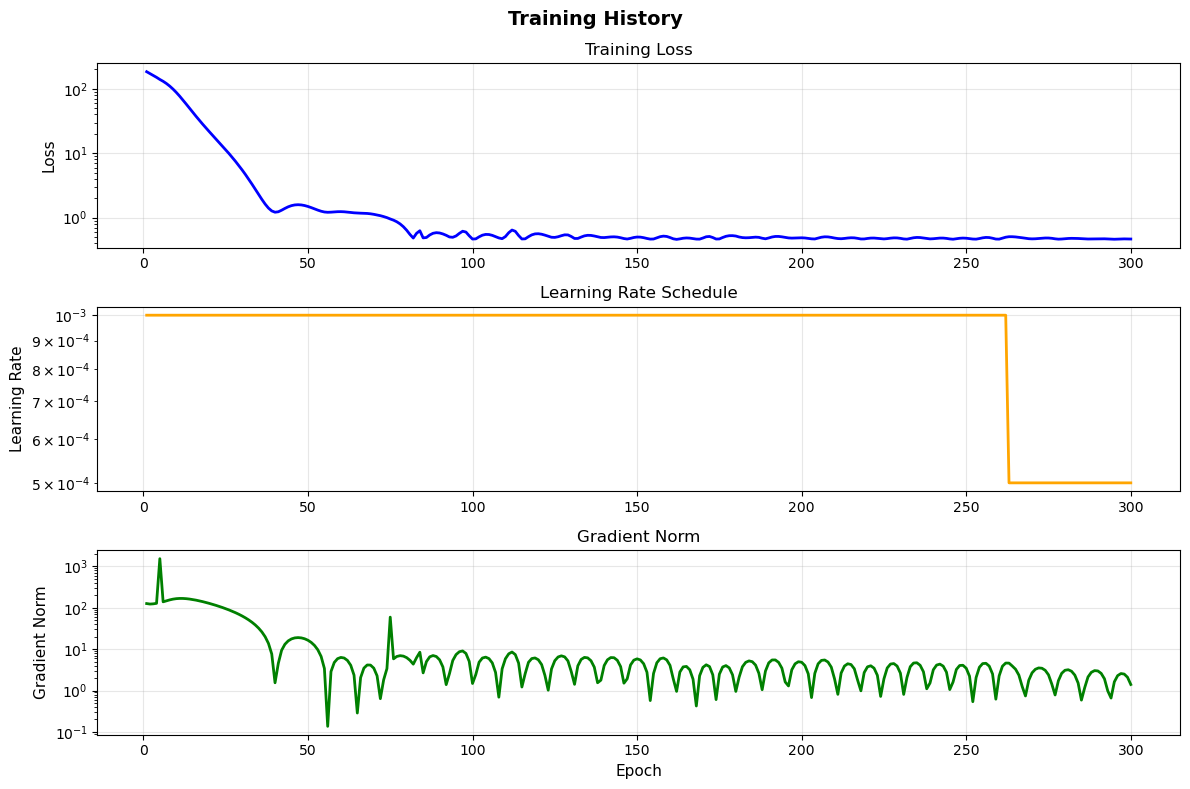

In [57]:
# Plot training history
history = trainer.get_history()
evaluator = UDEEvaluator(ude_model, STATE_NAMES)
evaluator.plot_training_history(history)


# 4. Evaluate UDE Performance


In [58]:
# Get predictions
with torch.no_grad():
    y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()

# Compute metrics
metrics = evaluator.compute_metrics(y_pred, y_true)
evaluator.print_metrics(metrics)



EVALUATION METRICS

X:
  R² score:  0.9980
  MAE:       0.0397
  RMSE:      0.0632
  MAPE:      0.67%

Y:
  R² score:  0.9992
  MAE:       0.0380
  RMSE:      0.0540
  MAPE:      0.70%

Overall:
  R² score:  0.9988
  MAE:       0.0388
  RMSE:      0.0588



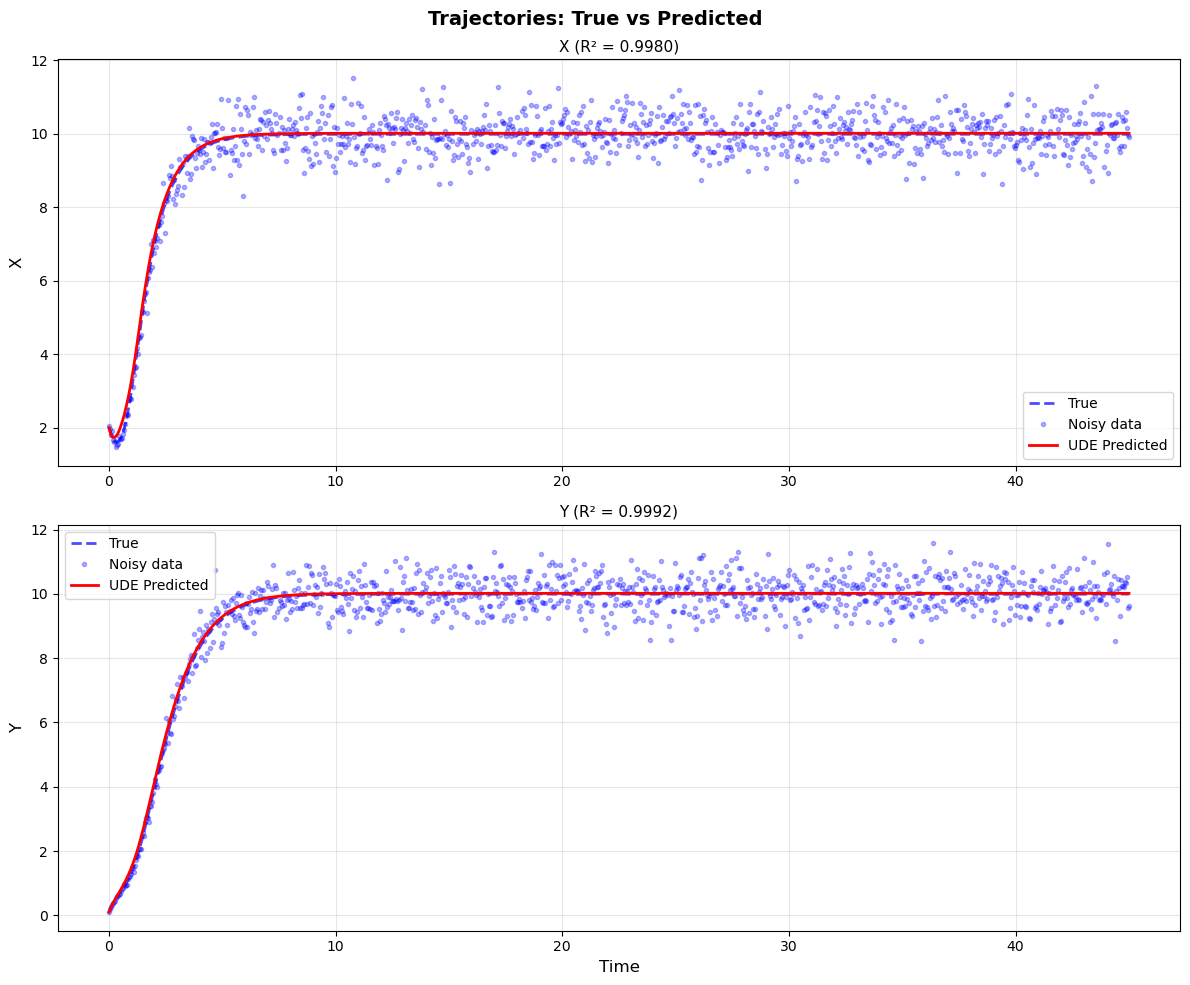

In [59]:
# Plot trajectories
evaluator.plot_trajectories(
    t=t,
    y_pred=y_pred,
    y_true=y_true,
    y_noisy=y_noisy
)


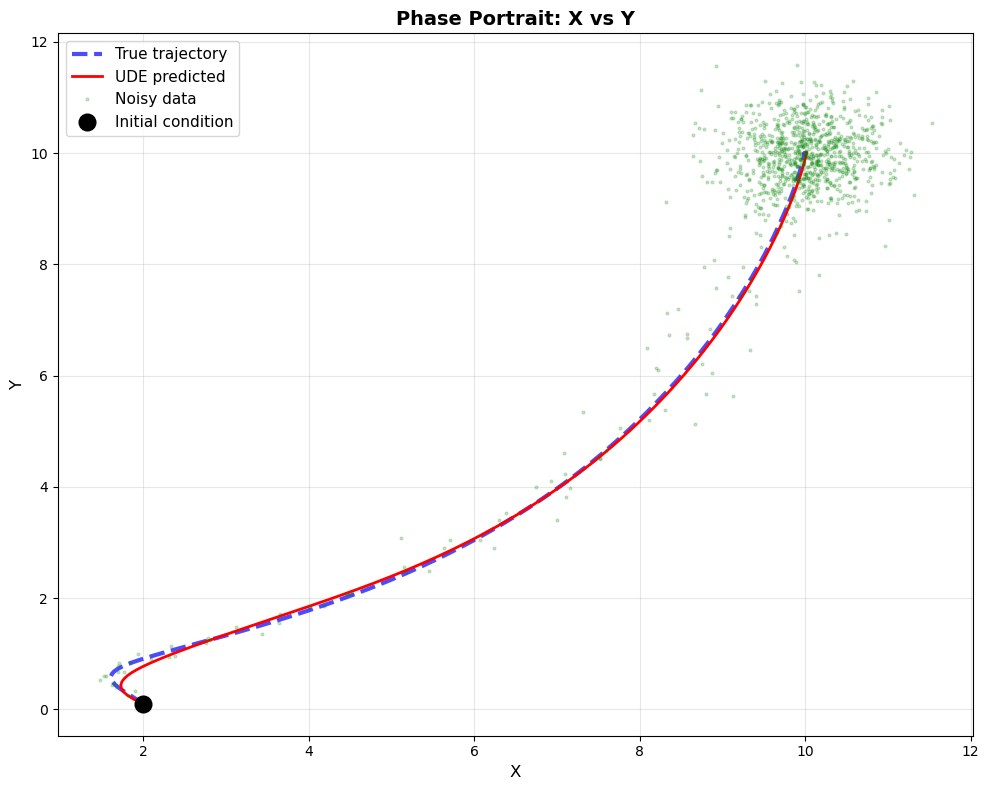

In [60]:
# Phase portrait (if 2D or higher)
if n_states >= 2:
    evaluator.plot_phase_portrait(
        y_pred=y_pred,
        y_true=y_true,
        y0=y0,
        y_noisy=y_noisy,
        state_indices=(0, 1)
    )


# 5. Compare Learned NN vs True Function


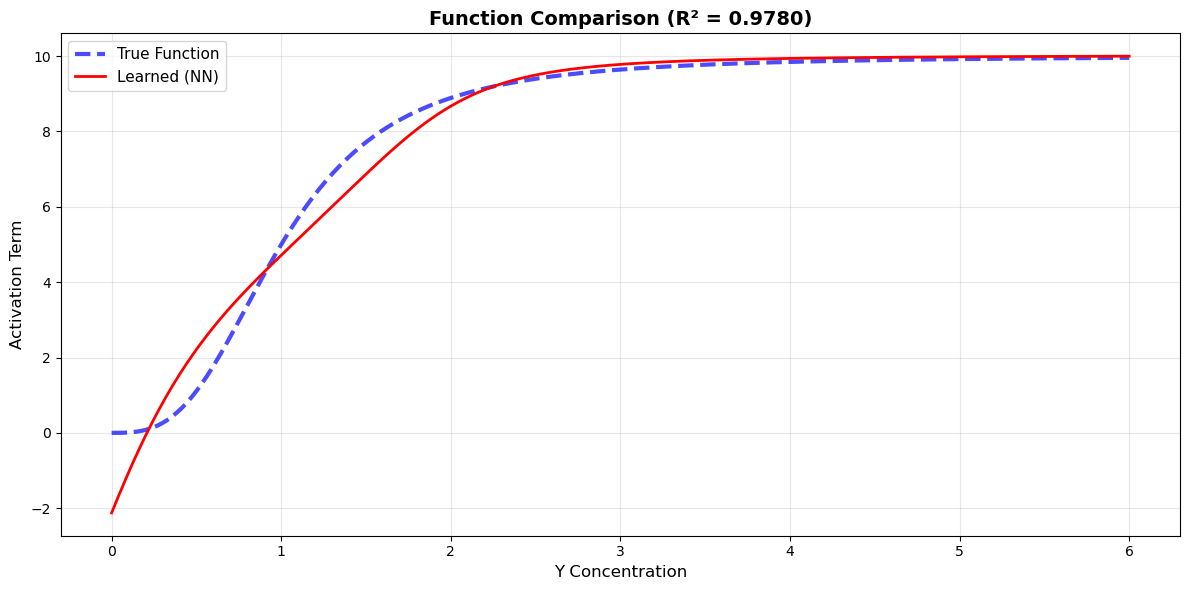


Function approximation metrics:
  R² score: 0.9780
  MAE: 0.2869
  RMSE: 0.4580
  MAPE: 70817744.10%


(0.9780336912963759, 0.2868553049929352, 0.45796007108796116)

In [61]:
# Compare learned NN to true function
evaluator.compare_learned_function(
    nn_model=nn_model,  # Use unwrapped NN
    true_function=true_function_for_comparison,
    input_range=FUNCTION_INPUT_RANGE,
    input_name=FUNCTION_INPUT_NAME,
    output_name=FUNCTION_OUTPUT_NAME
)


# 6. Extrapolation Test (Optional)


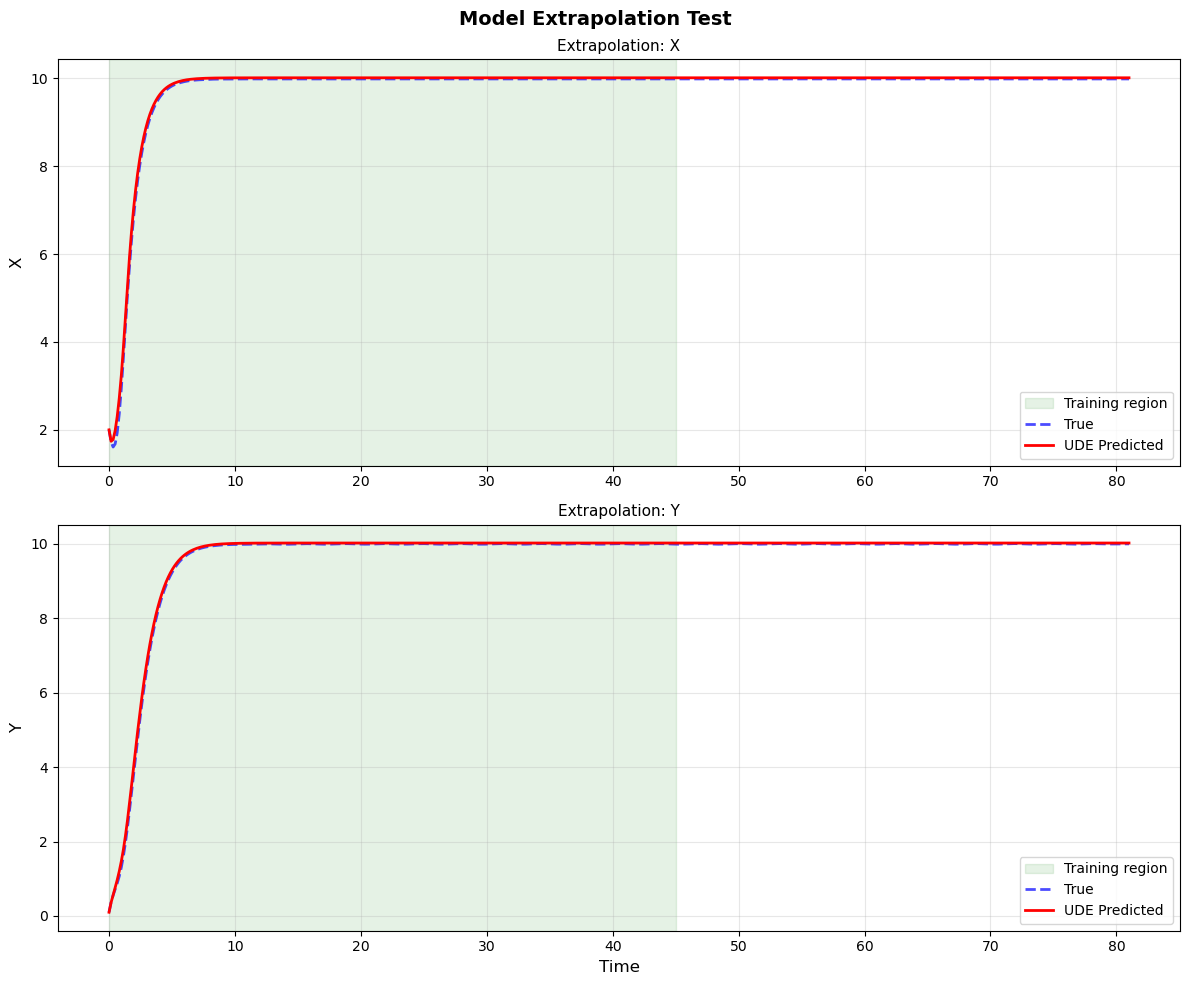


Extrapolation metrics (beyond t=45.0):
  X MAE: 0.0261
  Y MAE: 0.0246


In [62]:
# Test extrapolation to longer time
T_EXTENDED = T_END * 1.8
t_extended = np.linspace(T_START, T_EXTENDED, 500)

# Generate true solution for extended time
data_extended = data_gen.generate(
    initial_conditions=INITIAL_CONDITIONS,
    t_span=(T_START, T_EXTENDED),
    n_points=500,
    noise_level=0.0,
    random_seed=42
)

def true_solution_generator(t_vals):
    return data_extended['y_true']

# Run extrapolation test
evaluator.extrapolation_test(
    trainer=trainer,
    y0=y0_torch,
    t_train=t,
    t_extended=t_extended,
    true_generator=true_solution_generator
)
